Este colab contém duas implementações do modelo para resolver o Problema do Caixeiro Viajante

Para um problema com $n$ cidades, temos $i,j \in \{1,2 \dots ,n\}$.

$min \sum_{i,j} d_{ij}*X_{ij}$

$\sum_i X_{ij} = 1 \quad \forall \quad j$

$\sum_j X_{ij} = 1 \quad \forall \quad i$

$X_{jj} = 0 \quad \forall \quad i$

$X_{ij} \in \{0,1\} \quad \forall \quad i,j$

> O método de Dantzig, com a eliminação de sub-rotas

$\sum_{i,j} X_{ij} \leq |S| - 1 \quad \forall \quad i,j \in S$

> O Método MTZ

$u_i - u_j \leq n*(1-X_{ij}) - 1 \quad \forall \quad j, i \geq 2, i \neq j $

$u_{i} \geq 0 \quad \forall \quad i$


As instâncias foram retiradas do banco de dados TSPLIB

http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/



In [1]:
%pip install -i https://pypi.gurobi.com gurobipy
import gurobipy as gp
from gurobipy import GRB
import time
import math

Looking in indexes: https://pypi.gurobi.com
     ---------------------------------------- 9.6/9.6 MB 14.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
#FUNÇÃO PARA PLOTAR A SOLUÇÃO

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import networkx as nx

def plotTSP(sol, points):
    x = []; y = []
    for i in sol:
      x.append(points[i][0])
      y.append(points[i][1])
      
    plt.plot(x, y, 'co')
    
    a_scale = float(max(x))/float(100)

    plt.arrow(x[-1], y[-1], (x[0] - x[-1]), (y[0] - y[-1]), 
              head_width = a_scale, color ='g', length_includes_head=True)
    for i in range(0,len(x)-1):
      plt.arrow(x[i], y[i], (x[i+1] - x[i]), (y[i+1] - y[i]), 
                head_width = a_scale, color = 'g', length_includes_head = True)

    plt.xlim(min(x)*0.95, max(x)*1.05)
    plt.ylim(min(y)*0.95, max(y)*1.05)
    plt.show()
 

In [6]:
from google.colab import files
uploaded = files.upload()

ModuleNotFoundError: No module named 'google'

In [7]:
def find_next(X, j):
	for i in range(n):
		if round(X[j,i].X) == 1:
			next = i		
	return next

def ver_subtour(X,j):
	subtour = [j]
	next = find_next(X,j)
	while next != j:
		subtour.append(next)
		next = find_next(X,next)
	return subtour

def escreve_sol(X):
	solucao = []
	for j in range(n):
		j_sol = 0
		for i in range(len(solucao)):
			if j in solucao[i]:
				j_sol = 1			
		if j_sol == 0:
			subtour = ver_subtour(X,j)
			solucao.append(subtour)
	return solucao

In [8]:
with open('burma14.tsp', 'r') as f:
    data = [[num for num in line.split()] for line in f]

n = int(data[3][-1])

coord = []
for j in range(n):
  coord.append([])
  coord[j].append(float(data[j+6][-2]))
  coord[j].append(float(data[j+6][-1]))
d = []

for j in range(n):
	d.append([])
	for i in range(n):
		dist = math.sqrt( ((coord[j][0]-coord[i][0])**2)+((coord[j][1]-coord[i][1])**2) )
		d[j].append(dist)

In [9]:
model = gp.Model("Dantzig")
gp.setParam('LogToConsole', 0)

X = {}
X = model.addVars(n,n,vtype=GRB.BINARY)

distance = sum(X[j,i]*d[j][i] for j in range(n) for i in range(n))
model.setObjective(distance, GRB.MINIMIZE)

model.addConstrs(sum(X[j,i] for i in range(n)) == 1 for j in range(n))
model.addConstrs(sum(X[j,i] for j in range(n)) == 1 for i in range(n))
model.addConstrs(X[j,j] == 0 for j in range(n))
model.update()

start_time = time.time()

while True:
  model.optimize()	
  solucao = escreve_sol(X)
  n_rotas = len(solucao)
  print("\nNúmero de rotas: "+str(n_rotas))
  print(solucao)
  print("Valor: "+str(model.objVAL))
  if n_rotas != 1:
    for r in range(n_rotas):
      model.addConstr(sum(X[j,i] for j in solucao[r] for i in solucao[r]) <= len(solucao[r]) - 1)
    model.update()
  else:
    break

end_time = time.time()
print("\nTempo total: "+str(round(end_time-start_time,2)))

Restricted license - for non-production use only - expires 2024-10-28

Número de rotas: 6
[[0, 7, 1], [2, 13], [3, 4], [5, 11], [6, 12], [8, 9, 10]]
Valor: 26.671321013305565

Número de rotas: 4
[[0, 1], [2, 3, 4, 5, 11, 6, 12, 13], [7, 10], [8, 9]]
Valor: 29.486435262373206

Número de rotas: 1
[[0, 9, 8, 10, 7, 12, 6, 11, 5, 4, 3, 2, 13, 1]]
Valor: 30.878503892588

Tempo total: 0.02


[[0, 9, 8, 10, 7, 12, 6, 11, 5, 4, 3, 2, 13, 1]]
Valor: 30.878503892588

Tempo total: 0.13


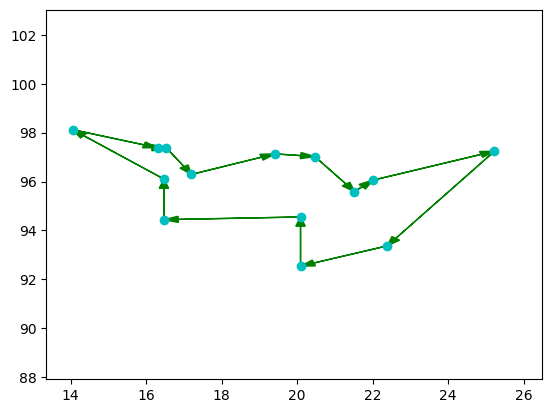

In [10]:
model = gp.Model("MTZ")
gp.setParam('LogToConsole', 0)

X = {}
X = model.addVars(n,n,vtype=GRB.BINARY)
u = {}
u = model.addVars(n,vtype=GRB.CONTINUOUS,lb=0)

distance = sum(X[j,i]*d[j][i] for j in range(n) for i in range(n))
model.setObjective(distance, GRB.MINIMIZE)

model.addConstrs(sum(X[j,i] for i in range(n)) == 1 for j in range(n))
model.addConstrs(sum(X[j,i] for j in range(n)) == 1 for i in range(n))
model.addConstrs(X[j,j] == 0 for j in range(n))

model.addConstrs(u[i] - u[j] <= n*(1-X[i,j]) - 1 
                 for j in range(n) for i in range(1,n) if i != j)

model.update()

start_time = time.time()
model.optimize()	
solucao = escreve_sol(X)
n_rotas = len(solucao)
print(solucao)
print("Valor: "+str(model.objVAL))
end_time = time.time()
print("\nTempo total: "+str(round(end_time-start_time,2)))

plotTSP(solucao[0], coord)